In [1]:
import scanpy as sc
import sys
sys.path.append("/corgi/debojyoti") 
import scSVAE

import math
import anndata

import torch

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np

import pandas as pd

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
#cell cycle genes
cc_mouse = pd.read_csv("/corgi/cellbuster/py/cc_mouse.csv")
cc_mouse = cc_mouse.iloc[:,1:]
cc_mouse.head()
cell_cycle_genes = [g.upper() for g in cc_mouse["symbol"].tolist()]
print(len(cell_cycle_genes))
print(cell_cycle_genes[:5])

93
['GMNN', 'RAD51', 'CDCA7', 'PRIM1', 'SLBP']


In [3]:
if True:
    ### Real data
    adata = sc.read("../scellgen2/data/small_rna.h5ad")
else:
    ### Create artificial data to fit
    num_cell = 1000

    gene1 = [np.random.poisson(int(abs(100*math.sin(float(v)*2*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene2 = [np.random.poisson(int(abs(100*math.cos(float(v)*2*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene3 = [np.random.poisson(int(abs(100*math.sin(float(v)*math.pi/num_cell)))) for v in range(0,num_cell)]
    gene4 = [np.random.poisson(int(abs(1+0*math.cos(float(v)*math.pi/num_cell)))) for v in range(0,num_cell)]

    X=[gene1,gene2,gene3,gene4]
    adata=anndata.AnnData(np.array(X).T)

    plt.plot(gene1)

In [4]:
adata

AnnData object with n_obs × n_vars = 25109 × 1863
    obs: 'batchname', 'cellbc', 'batch', 'sample_name', 'gc_zone', 'facs_genes', 'method', 'donor', '10xversion', 'trust4_celltype', 'batchnew', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'cellcycle', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'

In [5]:
sc.pp.subsample(adata, fraction=0.1)

In [6]:
adata

AnnData object with n_obs × n_vars = 2510 × 1863
    obs: 'batchname', 'cellbc', 'batch', 'sample_name', 'gc_zone', 'facs_genes', 'method', 'donor', '10xversion', 'trust4_celltype', 'batchnew', 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'S_score', 'G2M_score', 'phase', 'cellcycle', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome'

In [7]:
sc.pp.filter_genes(adata, min_counts=3)

In [8]:
adata.layers["counts"] = adata.X.copy() # preserve counts
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)
adata.raw = adata # freeze the state in `.raw`

In [9]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=1200,
    subset=True,
    layer="counts",
    flavor="seurat_v3"
)

In [10]:
# adata.obs

In [11]:
scSVAE.data.setup_anndata(
    adata,
    layer="counts",
    batch_key = "10xversion",
)

INFO     Using batches from adata.obs["10xversion"]                                          
INFO     No label_key inputted, assuming all cells have same label                           
INFO     Using data from adata.layers["counts"]                                              
INFO     Computing library size prior per batch                                              
INFO     Successfully registered anndata object containing 2510 cells, 1200 vars, 1 batches, 
         1 labels, and 0 proteins. Also registered 0 extra categorical covariates and 0 extra
         continuous covariates.                                                              
INFO     Please do not further modify adata until model is trained.                          


In [12]:
model = scSVAE.model.scSVAE(adata, n_latent = 2)

In [13]:
model.train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/400:   0%|                                                                                                           | 0/400 [00:00<?, ?it/s]

/home/pcddas/miniconda3/envs/scvi-env/lib/python3.7/site-packages/torch/distributions/distribution.py:46: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


Epoch 400/400: 100%|████████████████████████████████████████████████████████████████████████████| 400/400 [03:18<00:00,  2.01it/s, loss=389, v_num=1]


In [14]:
model.history.keys()

dict_keys(['train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'train_loss_step'])

In [15]:
model.get_reconstruction_error()

/home/pcddas/miniconda3/envs/scvi-env/lib/python3.7/site-packages/torch/distributions/distribution.py:46: UserWarning: <class 'hyperspherical_vae.distributions.hyperspherical_uniform.HypersphericalUniform'> does not define `arg_constraints`. Please set `arg_constraints = {}` or initialize the distribution with `validate_args=False` to turn off validation.
  'with `validate_args=False` to turn off validation.')


{'reconstruction_loss': -367.76401347734065}

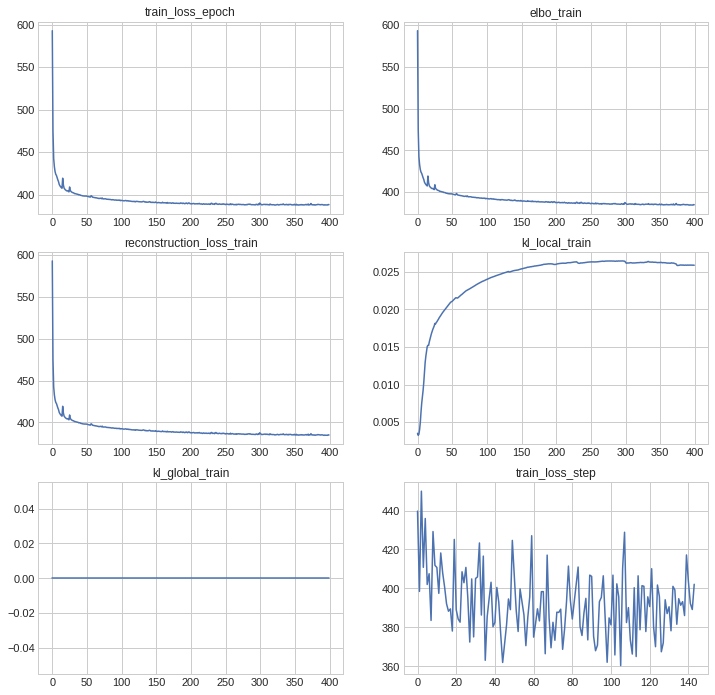

In [16]:
plt.figure(figsize=(12,12))
for i, loss in enumerate(model.history.keys()):
    plt.subplot(3, 2,i+1)
    df = model.history[loss]
    plt.plot(df.iloc[:,0].values)
    plt.title(df.columns.tolist()[0])

In [17]:
latent = model.get_latent_representation()
# adata.obsm["X_scSVAE"] = latent

In [18]:
adata.obsm["X_pca"] = latent

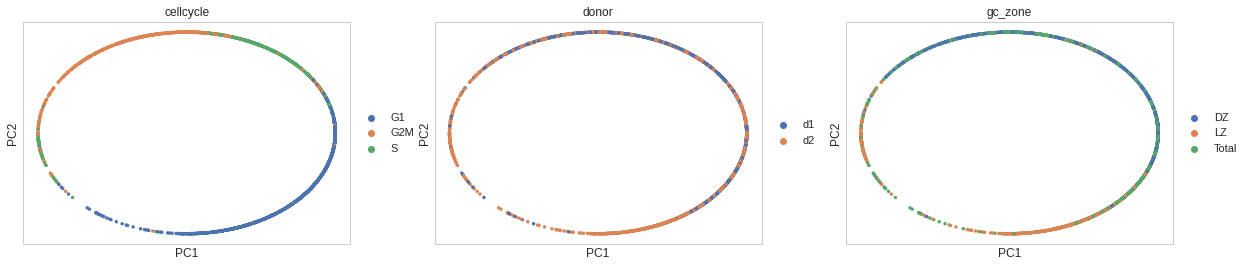

In [19]:
sc.pl.pca(adata, color = ["cellcycle", "donor", "gc_zone"])

In [20]:
# sc.pp.neighbors(adata)#, use_rep="X_scSVAE")

In [21]:
# sc.tl.umap(adata)

In [22]:
# sc.pl.umap(adata, color = ["donor", "cellcycle"])

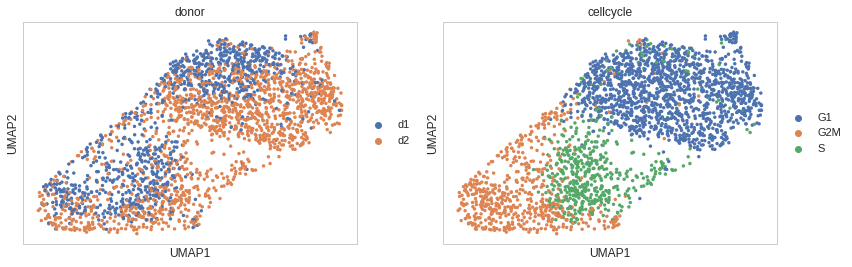

In [23]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.pl.umap(adata, color = ["donor", "cellcycle"])

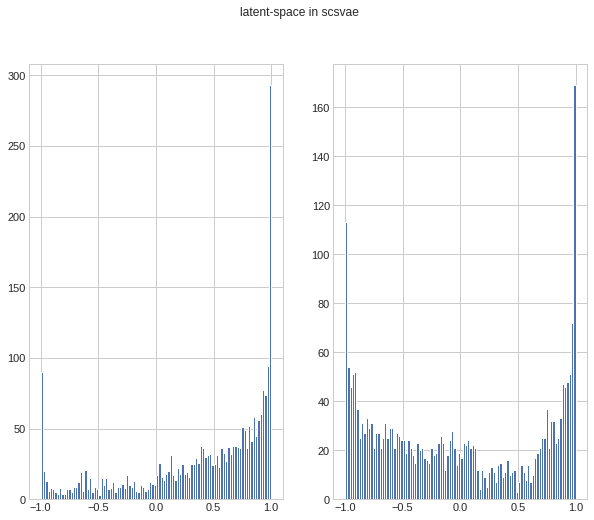

In [24]:
plt.figure(figsize=(10,8))
plt.suptitle("latent-space in scsvae")
plt.subplot(121)
plt.hist(latent[:,0], bins =100)
plt.subplot(122)
plt.hist(latent[:,1], bins =100)
plt.show()

In [25]:
r, theta = model.module.get_polar(adata.obsm["X_pca"][:,0], adata.obsm["X_pca"][:,1])

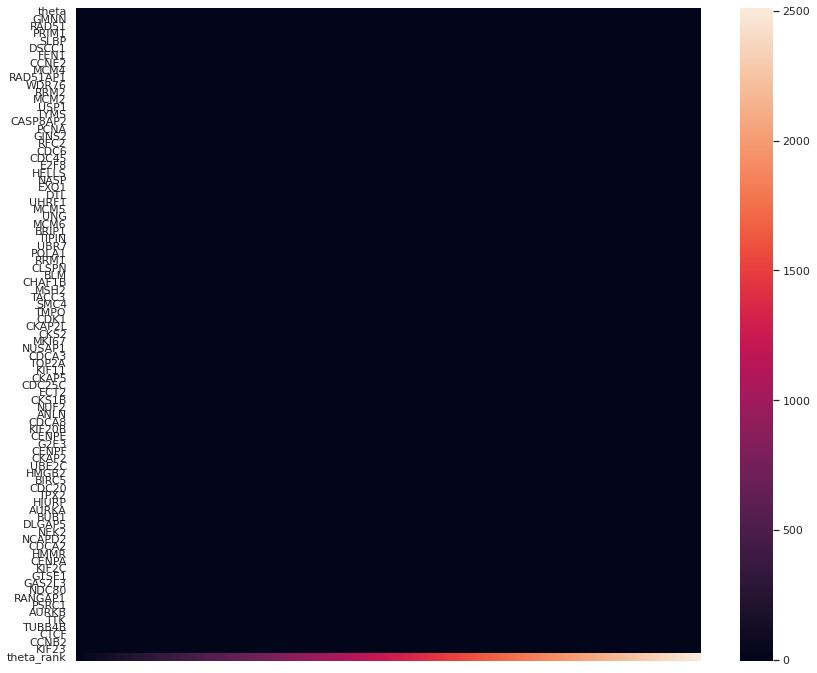

In [26]:
model.module.gene_heatmap(adata, theta, cell_cycle_genes)

In [27]:
# for param in model.get_likelihood_parameters():
#     print(param)

In [28]:
# model.get_likelihood_parameters().keys()

In [29]:
# latent.shape

In [30]:
# decoder = scvi.nn.DecoderSCVI(10, 1200, n_cat_list=None, n_layers=1, n_hidden=128)

decoder

In [31]:
# from scvi.model._utils import *
# from scvi import _CONSTANTS
# from scvi.data._utils import _compute_library_size, _compute_library_size_batch

In [32]:
# _compute_library_size_batch(adata,'10xversion')

In [33]:
# l_size = torch.zeros(1,25109)

In [34]:
# for i, v in enumerate(adata.obs["_scvi_local_l_mean"].tolist()):
#     l_size[0,i] = v

# l_size.shape

In [35]:
# torch.tensor(latent).shape, torch.tensor(adata.obs["_scvi_local_l_mean"]).shape

In [36]:
## ZINB parameters from SCVI

In [37]:
# px_scale, px_r, px_rate, px_dropout = decoder.forward("gene", torch.tensor(latent), l_size)

In [38]:
from abc import ABC

In [39]:
class a(ABC):
    def am(self):
        pass

In [40]:
class childa(a):
    def am(self):
        pass
    def cm(self):
        print("additional method")

In [41]:
instance_child = childa()

In [42]:
instance_child.cm()

additional method
